# Introduction
---
The purpose of this notebook is to generate and compute the 1-edit distance between all the possible rooted and unlabeled trees given a fixed `depth` and `maximum_degree`.

## Notebook configuration
Configure several notebook configuration settings.

In [40]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [41]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

# Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [45]:
!ls "../data/synthetic/erdos_renyi"

N100_n100_p0.1_1624367054 N100_n30_p0.1_1624230420


In [48]:
!ls "../data/synthetic/erdos_renyi/N100_n100_p0.1_1624367054/teacher_outputs/regression/GIN"

num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373362910
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373363205
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373363387
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373363566
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373363742
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373363934
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373364137
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373364321
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373364499
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1__1624373364675


In [70]:
teacher_outputs_prefix = "../data/synthetic/erdos_renyi/N100_n100_p0.1_1624367054/teacher_outputs/regression/GIN"

# Retrieve different teacher output configurations
teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x[-13:]])]
teacher_outputs_configs = ['__'.join(x.split('__')[:-1]) for x in teacher_outputs_filenames]
# Make sure to work only with the same teacher configurations
assert teacher_outputs_configs.count(teacher_outputs_configs[0]) == len(teacher_outputs_configs), \
    'Please specify teacher configuration! (there are more than one configuration available)'
print(f"Results over {len(teacher_outputs_filenames)} different teacher initializations, using the folowing configuration:")
print(teacher_outputs_filenames[0][:-15])

# Retrieve available student models
students = set([
    x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs') if x != '.DS_Store'
])
print()
print(f"Student outputs computed with the following models: {', '.join(students)}")

# Retrieve the different distance matrices used for computing the smoothness
dist_matrices = set()
for teacher_outputs_filename in teacher_outputs_filenames:
    for student in students:
        dist_matrix_smoothness = [
            x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filename}/student_outputs/{student}/smoothness') 
            if x.endswith('.csv')
        ]
        for dist_matrix in dist_matrix_smoothness:
            dist_matrices.add(dist_matrix.rstrip('.csv'))
print()
print(f"Smoothness computed with the following distance matrices: {', '.join(dist_matrices)}")

Results over 10 different teacher initializations, using the folowing configuration:
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1

Student outputs computed with the following models: GCN, Baseline, GIN

Smoothness computed with the following distance matrices: WL__hashing__d3_iOnes__hamming__sMaxdegree


---
Fix the `dist matrix` and the `teacher architecture`, and read all the available data for all the available combinations.

In [99]:
DIST_MATRIX = 'WL__hashing__d3_iOnes__hamming__sMaxdegree'

In [95]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename, model):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = (pd.read_csv(smoothness_filename, header=[0, 1], index_col=0)
                          .reset_index()
                          .rename(columns={'index': 'model_config'}))
    # Add an extra column with the model type (for later processing)
    smoothness_stats['model'] = [model] * len(smoothness_stats)
    # Rearange column order for better visualization
    cols = smoothness_stats.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    return smoothness_stats[cols]

In [97]:
# Test method with a sample
sample_filename = f"{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs/GIN/smoothness/{DIST_MATRIX}.csv"
sample_smoothness_stats = readSmoothnessCSV(sample_filename, model='GIN')
# Save ordered columns for later processing
ordered_cols = sample_smoothness_stats.columns.tolist()
sample_smoothness_stats

model                                       model_config               0  \
                                                           mean_smoothness   
0   GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...        0.161347   
1   GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...        1.444393   

                                                          1  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.284698  0.517959     0.081921        3.704228   
1           1.469585  0.525974     0.286055        4.114533   

                                                          2  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.448261  0.031732     0.011981        3.931013   
1           0.092545  0.008864     0.007002        4.128061   

                                                          3  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.169515  0.021079     0.011209        4.059537   
1           0.116017  0.004978     0.004651        4.164031   

                                                          4  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.144355  0.008320     0.005738        4.154589   
1           0.050895  0.002522     0.002398        4.182329   

                                                          5  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.073464  0.005507     0.003681        4.172434   
1           0.024355  0.002344     0.001521        4.175763   

                                                          6  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.030223  0.003746     0.001805        4.163180   
1           0.014542  0.001616     0.001149        4.175362   

                                                          7  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.019712  0.002774     0.000978        4.162100   
1           0.025934  0.002340     0.001987        4.187974   

                                                          8  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.021542  0.002881     0.001098        4.171343   
1           0.044935  0.002512     0.002272        4.161577   

                                                          9  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.019862  0.003001     0.000853        4.217849   
1           0.043516  0.002041     0.001230        4.171169   

                                                         10  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0           0.069332  0.005297     0.003443         4.20240   
1           0.026598  0.001654     0.001563         4.17387   

                                             
  std_dev_smoothness mean_rmse std_dev_rmse  
0           0.075107  0.003977     0.003426  
1           0.019045  0.001518     0.000908

In [101]:
# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in tqdm(teacher_outputs_filenames):
    for student in students:
        student_outputs_filename = \
            f"{teacher_outputs_prefix}/{teacher_outputs_filename}/student_outputs/{student}/smoothness/{DIST_MATRIX}.csv"
        smoothness_stats = smoothness_stats.append(
            readSmoothnessCSV(student_outputs_filename, model=student), ignore_index=True)
smoothness_stats = smoothness_stats[ordered_cols]
smoothness_stats

  0%|          | 0/10 [00:00<?, ?it/s]

model                                       model_config  \
                                                                  
0        GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
1   Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
2        GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
3        GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
4        GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
5   Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
6        GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
7        GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
8        GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
9   Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
10       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
11       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
12       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
13  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
14       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
15       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
16       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
17  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
18       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
19       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
20       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
21  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
22       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
23       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
24       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
25  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
26       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
27       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
28       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
29  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
30       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
31       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
32       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
33  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
34       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
35       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   
36       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
37  Baseline    WL__hashing__d3_iOnes__hamming__sMaxdegree__knn   
38       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
39       GIN  num1_hidden32_blocks3_residualFalse_jkTrue__bi...   

                 0                                                         1  \
   mean_smoothness std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0         0.205909           0.341442  0.531926     0.201731        2.307958   
1         4.169379           0.000000  0.008526     0.000000             NaN   
2         0.161347           0.284698  0.517959     0.081921        3.704228   
3         1.444393           1.469585  0.525974     0.286055        4.114533   
4         0.113081           0.079308  0.446170     0.177292        1.692998   
5         3.285040           0.000000  0.016575     0.000000             NaN   
6         0.160057           0.275136  0.531294     0.083877        3.060610   
7         1.936377           2.761636  0.406734     0.246671        3.317684   
8         0.073010           0.067966  0.740877     0.402790        0.113930   
9         0.218145           0.000000  0.035503     0.000000             NaN   
10        0.107300           0.181479  0.432507     0.291533        0.237766   
11        0.969013           2.143715  0.732630     0.668701        0.223191   
12        0.093860           0.136025  0.969076     0.641620        0.04

Average the results throughout the different teacher initializations.

In [107]:
#warnings.filterwarnings('ignore', category='PerformanceWarning')

smoothness_stats_avg = smoothness_stats.groupby(['model', 'model_config']).mean()
smoothness_stats_avg

/Users/berges/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


0  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn           1.066916   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...        0.141903   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...        0.200524   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...        1.615170   

                                                                                \
                                                            std_dev_smoothness   
model    model_config                                                            
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn              0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...           0.181836   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...           0.329263   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...           1.805940   

                                                                       \
                                                            mean_rmse   
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn     0.050345   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.758863   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.554102   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  1.240394   

                                                                          \
                                                            std_dev_rmse   
model    model_config                                                      
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn        0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     0.449621   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     0.305505   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...     0.778472   

                                                                          1  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn                NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...        0.549323   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...        0.990574   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...        1.078195   

                                                                                \
                                                            std_dev_smoothness   
model    model_config                                                            
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn                   NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...           0.159880   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...           0.117468   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...           0.031242   

                                                                       \
                                                            mean_rmse   
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.098224   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.040543   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.037198   

                                                                          \
                                                            std_dev_rmse   
model    model_config                                                      
Baseline WL__hashing__d3_iOnes_

### Visualization
---
Visualize the averaged obtained results

In [125]:
num_epochs = np.max(list(map(int, smoothness_stats_avg.columns.get_level_values(0))))

epochs = list(range(num_epochs + 1))

# Retrieve mean smoothness
mean_smoothness = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == 'mean_smoothness']
mean_smoothness.columns = mean_smoothness.columns.droplevel(1)
# Retrieve std dev smoothness
std_dev_smoothness = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == 'std_dev_smoothness']
std_dev_smoothness.columns = std_dev_smoothness.columns.droplevel(1)
# Retrieve mean RMSE
mean_rmse = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == 'mean_rmse']
mean_rmse.columns = mean_rmse.columns.droplevel(1)
# Retrieve std dev smoothness
std_dev_rmse = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == 'std_dev_rmse']
std_dev_rmse.columns = std_dev_rmse.columns.droplevel(1)

0  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn     0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.181836   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.329263   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  1.805940   

                                                                    1  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.159880   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.117468   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.031242   

                                                                    2  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.053178   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.055519   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.033893   

                                                                    3  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.044959   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.039695   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.035499   

                                                                    4  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.041276   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.027755   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.016766   

                                                                    5  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.044482   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.020792   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.015753   

                                                                    6  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.043277   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.020767   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.021522   

                                                                    7  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.036552   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.028691   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.018951   

                                                                    8  \
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__sMaxdegree__knn          NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.042664   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.019504   
         num1_hidden32_blocks3_residualFalse_jkTrue__bia...  0.023901   

                                                                    9  \
model    model_config                       

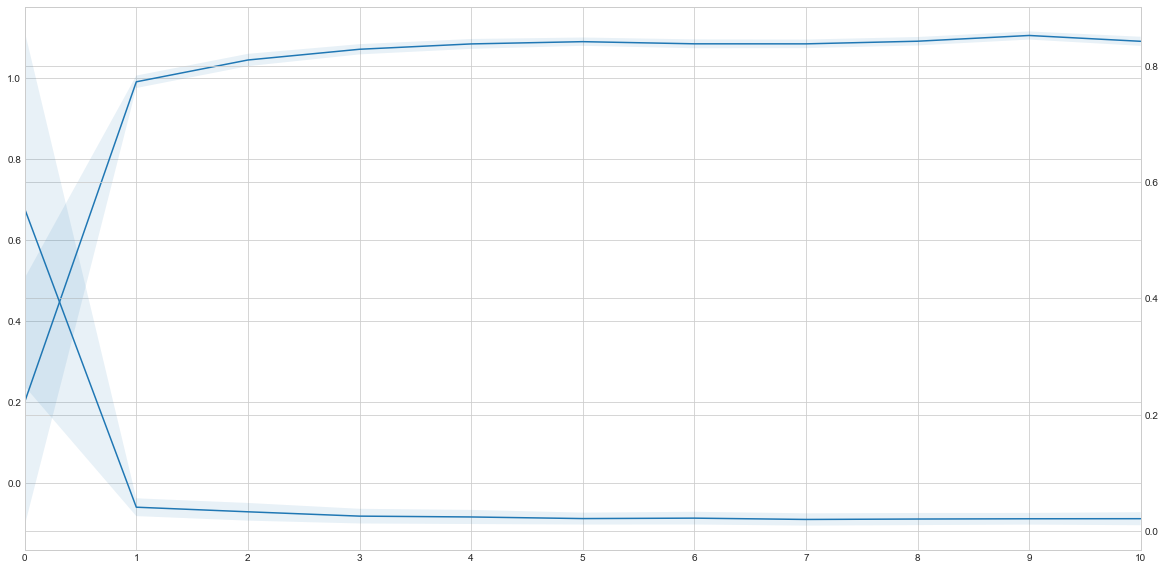

In [143]:


model_config = ('GIN', 'num1_hidden32_blocks3_residualFalse_jkFalse__bias0_lower-0.1_upper0.1')

fig, ax = plt.subplots(figsize=(20, 10))

x = epochs.copy()
y = mean_smoothness.loc[model_config].to_numpy()
std_dev = std_dev_rmse.loc[model_config].to_numpy()
y2 = mean_rmse.loc[model_config].to_numpy()
std_dev2 = std_dev_rmse.loc[model_config].to_numpy()

ax.plot(x, y, label=f"{model_config[0]} ({model_config[1]})")
ax.fill_between(x, (y - std_dev), (y + std_dev), alpha=0.1)

# Add twin performance RMSE
ax2 = ax.twinx()
ax2.plot(x, y2, label=f"{model_config[0]} ({model_config[1]})")
ax2.fill_between(x, (y2 - std_dev2), (y2 + std_dev2), alpha=0.1)

ax.set_xlim(left=epochs[0], right=epochs[-1])
ax.set_xticks(epochs)
#ax.legend()

plt.show()

In [127]:
mean_smoothness.loc[('GIN', 'num1_hidden32_blocks3_residualFalse_jkFalse__bias0_lower-0.1_upper0.1')].tolist()

[0.20052419493972035,
 0.990573815421927,
 1.0443954078195368,
 1.0708917760119667,
 1.0840880575181286,
 1.0896696273491078,
 1.0843503943888717,
 1.08424743282486,
 1.0907558806811621,
 1.104930024073393,
 1.0905388969037122]

In [145]:
# way to get all index combinations
mean_smoothness.index.tolist()

[('Baseline', 'WL__hashing__d3_iOnes__hamming__sMaxdegree__knn'),
 ('GCN',
  'num1_hidden32_blocks3_residualFalse_jkFalse__bias0_lower-0.1_upper0.1'),
 ('GIN',
  'num1_hidden32_blocks3_residualFalse_jkFalse__bias0_lower-0.1_upper0.1'),
 ('GIN',
  'num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1')]